## Exploring a single simulation

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import matplotlib.gridspec as gridspec
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
from matplotlib.animation import FuncAnimation, writers, PillowWriter
from copy import copy
from glob import glob
from datetime import timedelta

In [3]:
datadir = '/data/oceanparcels/output_data/data_Reint/'#'/scratch/rfischer/Kooi_data/data_output/'
regions = {'EqPac': 'Equatorial Pacific',
           'GPGP': 'Great Pacific Garbage Patch',
           'SO': 'Southern Ocean',
           'NPSG': 'North Pacific Subtropical Gyre'}

In [4]:
r_pl_clist = ['#7a0177','#c51b8a','#f768a1', '#fbb4b9']
r_pl_cmap = plt.get_cmap('RdPu_r')

In [5]:
region = 'EqPac'
mortality = 0.39              # [d-1]
runtime =365                  # [days]
dt = 60                       # [seconds]
outputdt = 12                  # [hours]
death = 'NEMO_detritus'
grazing = 'full'
mixing = 'markov_0_KPP_reflect'+death+'_tidal'
diss = 0.006
rho_p = 920
rho_bf = 1388
rho_fr= 1800
sizebinedges = [1e-3, 1e-4, 1e-5]
res = '1x1'
proc = 'bfnoadv'

In [6]:
ds = xr.open_dataset(datadir+'regional_'+region+'_'+proc+'_Jan_2004_'+res+'res_'+mixing+'mixing_'+grazing+'_grazing_'+str(diss)[2:]+'diss_'+str(rho_bf)+'rhobf_'+str(rho_fr)+'rhofr_'+str(runtime)+'days_'+str(dt)+'dtsecs_'+str(outputdt)+'hrsoutdt.nc')#'/data/oceanparcels/output_data/data_Reint/'+'regional_SO_bfnoadv_Jan_2004_1x1res_markov_0_KPP_reflectNEMO_detritus_tidalmixing_full_grazing_006diss_1388rhobf_2200rhofr_10days_60dtsecs_60hrsoutdt.nc')

In [7]:
# filename = datadir+'regional_'+region+'_'+proc+'_Jan_2004_'+res+'res_'+mixing+'mixing_'+grazing+'_grazing_'+str(diss)[2:]+'diss_1250rhobf_'+str(runtime)+'days_'+str(dt)+'dtsecs_'+str(outputdt)+'hrsoutdt.nc'
# print(filename)
# ds = xr.open_dataset(filename)

In [8]:
# ds = xr.open_dataset(datadir+'regional_'+region+'_'+proc+'_Jan_2004_'+res+'res_'+mixing+'mixing_'+grazing+'_grazing_'+str(diss)[2:]+'diss_'+str(rho_bf)+'rhobf_'+str(rho_fr)+'rhofr_'+str(runtime)+'days_'+str(dt)+'dtsecs_'+str(outputdt)+'hrsoutdt.nc')

In [9]:
# times = ds['time'][:].astype('O')
# timelabels = ds['time'][:].dt.strftime('%Y-%m-%d')

In [52]:
number_of_trajectories_to_plot = 1333
n_plt = number_of_trajectories_to_plot
f_plt = int(np.round(len(ds['traj'])/n_plt))
print('plotting '+str(n_plt)+' of '+str(len(ds['traj']))+' trajectories')
print('plotting every '+str(f_plt)+' particles')

plotting 1333 of 10000 trajectories
plotting every 8 particles


In [16]:
sizes = copy(ds['r_pl'][:].values)
ids = np.argsort(sizes)[::-1]
sizes = sizes[ids]
lons = copy(ds['lon'][:].values)[ids]
lats = copy(ds['lat'][:].values)[ids]
depths = copy(ds['z'][:].values)[ids]
algae = copy(ds['d_phy'][:].values)[ids]
sizecolors = (np.log10(sizes)-np.log10(sizes.min()))*256/(np.log10(sizes.max())-np.log10(sizes.min()))
times = copy(ds['time'][:].values)[ids]
sqrtsizes = np.sqrt(sizes)

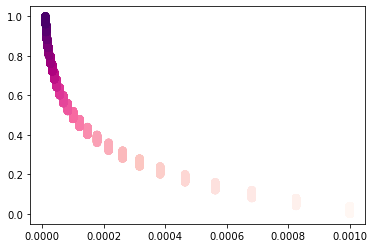

In [12]:
c= r_pl_cmap(sizecolors.astype(int))
plt.scatter(sizes,np.linspace(0,1,len(c)),s=50,color=c)

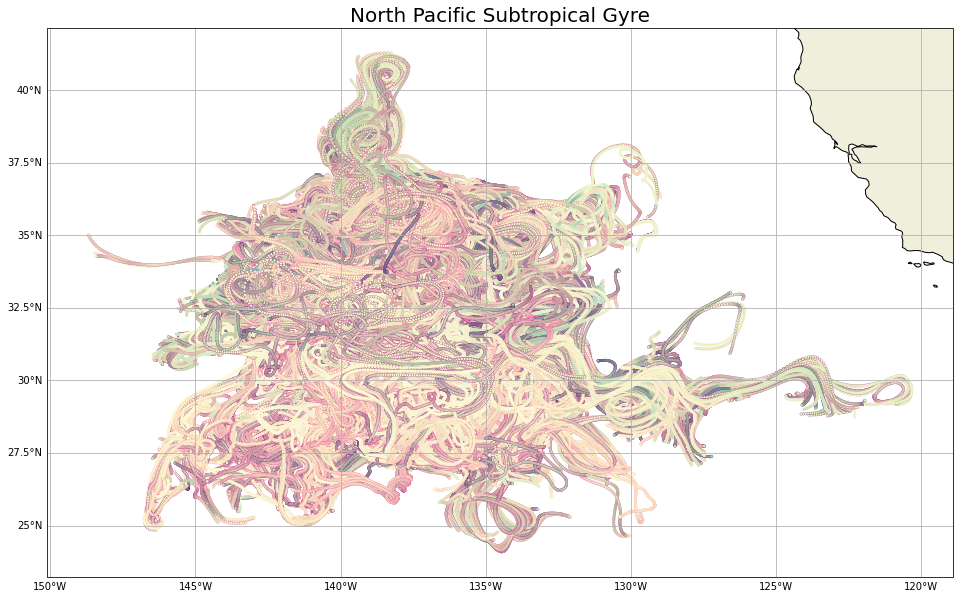

In [31]:
fig = plt.figure(figsize=(16,8), constrained_layout=True)
ax = plt.axes(projection=ccrs.PlateCarree(180))
ax.set_title(regions[region], fontsize=20)
c= r_pl_cmap(sizecolors.astype(int))
ax.scatter(lons,lats,c=depths,cmap='cmo.deep',s=7, edgecolors=c,linewidth=0.2, transform=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.LAND)

gl = ax.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# ax.set_extent([165,240,-15,15], crs=ccrs.PlateCarree())
# ax.set_ylim(np.mean(ds['lat'])-15,np.mean(ds['lat'])+15)
# ax.set_xlim(np.mean(ds['lon'].where(ds['lon']<0))-45+180,np.mean(ds['lon'].where(ds['lon']<0))+26+180)
# ax.set_xlim(np.mean(ds['lon'])-15,np.mean(ds['lon'])+30)
plt.show()

In [167]:
# outputdt = timedelta(hours=6)

# timerange = np.arange(np.nanmin(ds['time'].values),
#                       np.nanmax(ds['time'].values)+np.timedelta64(outputdt),
#                       outputdt)  # timerange in nanoseconds\n",
    
outputdt = timedelta(hours=6)

timerange = np.arange(np.nanmin(times),
                      np.nanmax(times)+outputdt.seconds, #+np.timedelta64(outputdt), #
                      outputdt.seconds) #  # timerange in nanoseconds\n",

timedays = np.zeros(len(timerange), dtype='<U64')
for i in range(len(timerange)):
    timedays[i] = np.datetime64('2004-01-01')+np.timedelta64(int(timerange[i]),'s')
timedays = np.unique(timedays)

In [67]:
time_id = np.where(np.logical_and(ds['time'] >= timerange[0],ds['time'] < timerange[1])) # All trajectory data for a single day

In [68]:
%matplotlib notebook

In [69]:
def getclosest_ij(lats,lons,latpt,lonpt):
    """Function to find the index of the closest point to a certain lon/lat value."""
    dist_sq = (lats-latpt)**2 + (lons-lonpt)**2                 # find squared distance of every point on grid
    minindex_flattened = dist_sq.argmin()                       # 1D index of minimum dist_sq element
    return np.unravel_index(minindex_flattened, lats.shape)     # Get 2D index for latvals and lonvals arrays from 1D index

In [121]:
# dirread = '/data/oceanparcels/input_data/NEMO-MEDUSA_BGC/ORCA0083-N006/means/'
# yr = '2004'
# yr0 = yr
# bgcfiles = sorted(glob(dirread+'*'+yr+'*P.nc'))
mesh_mask = xr.open_dataset('/data/oceanparcels/input_data/NEMO-MEDUSA/ORCA0083-N006/domain/coordinates.nc', decode_times=False)
# ds_bgc = xr.open_dataset(bgcfiles[0])
# fielddepths= ds_bgc['deptht'][:20]

# xmin = (np.mean(ds['lon'])-10).values
# xmax = (np.mean(ds['lon'])+10).values
# ymin = (np.mean(ds['lat'])-7).values
# ymax = (np.mean(ds['lat'])+7).values

# jmin, imin = getclosest_ij(mesh_mask['glamf'][0].values,mesh_mask['gphif'][0].values,xmin,ymin)
# jmax, imax = getclosest_ij(mesh_mask['glamf'][0].values,mesh_mask['gphif'][0].values,xmax,ymax)

In [136]:
dirread = '/data/oceanparcels/input_data/NASA_GISS/modelE/'
yr = '2004'
yr0 = yr
bgcfiles = sorted(glob(dirread+yr+'*obijlh*.nc'))
# mesh_mask = xr.open_dataset('/data/oceanparcels/input_data/NEMO-MEDUSA/ORCA0083-N006/domain/coordinates.nc', decode_times=False)
ds_bgc = xr.open_dataset(bgcfiles[0])
fielddepths= ds_bgc['zoc']

xmin = (np.mean(ds['lon'])-12).values-5
xmax = (np.mean(ds['lon'])+20).values+5
ymin = (np.mean(ds['lat'])-10).values-5
ymax = (np.mean(ds['lat'])+10).values+5

lonvals, latvals = np.meshgrid(ds_bgc['lono'].values, ds_bgc['lato'].values)
jmin, imin = getclosest_ij(lonvals,latvals,xmin,ymin)
jmax, imax = getclosest_ij(lonvals,latvals,xmax,ymax)

In [137]:
# diatoms = np.zeros((len(bgcfiles[:18]),ds_bgc['PHD'][0, :20, jmin:jmax-1, imin:imax-1].shape[0],ds_bgc['PHD'][0, :20, jmin:jmax-1, imin:imax-1].shape[1],ds_bgc['PHD'][0, :20, jmin:jmax-1, imin:imax-1].shape[2]))

In [138]:
diatoms = np.zeros((len(bgcfiles[:18]),ds_bgc['diat'][0, 0, jmin:jmax-1, imin:imax-1].shape[0],ds_bgc['diat'][0, 0, jmin:jmax-1, imin:imax-1].shape[1]))

In [139]:
for i, filename in enumerate(bgcfiles[:18]):
    ds_b = xr.open_dataset(filename)
    diatoms[i] = ds_b['diat'][0, 0, jmin:jmax-1, imin:imax-1]

In [175]:
fig = plt.figure(figsize=(14.5,7))
# fig.suptitle(regions[region], fontsize=18, fontweight='bold', y=0.9)
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 21, 1])

axcb0 = plt.subplot(gs[0])
axcb1 = plt.subplot(gs[2])
# ax = plt.subplot(gs[1],projection=ccrs.PlateCarree(180))
ax = plt.subplot(gs[1],projection=ccrs.PlateCarree())
# ax = plt.axes()

ax.set_ylim(ymin+5,ymax-5)
# ax.set_xlim(np.mean(ds['lon'].where(ds['lon']<0))-10+180,np.mean(ds['lon'].where(ds['lon']<0))+10+180)
ax.set_xlim(xmin+5,xmax-5)

pc = ax.pcolormesh(lonvals[jmin:jmax,imin:imax],latvals[jmin:jmax,imin:imax],diatoms[0], cmap='cmo.algae', vmax=0.5, zorder=1) #, transform=ccrs.PlateCarree())

# ax.coastlines()
ax.add_feature(cfeature.LAND, color='k',zorder=2)
# ax.set_facecolor([31./256., 93./256., 133./256., 1.])

# gl =ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), xlocs=[-140, -130, -120, -110, -100, -90])
# gl =ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), xlocs=[-170, -160, -150,-140,-130,-120, 150, 160, 170, 180])
gl =ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), xlocs=[-20, -10, 0, 10, 20, 30])
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()
gl.xlabel_style = {'size': 13}
gl.ylabel_style = {'size': 13}

ax.scatter([0.03,0.03],[0.81,0.86],color=plt.get_cmap('cmo.matter')(150),s=[np.max(sqrtsizes)*1000,np.min(sqrtsizes)*1000], zorder=5, transform=ax.transAxes)

size_text0 = ax.text(0.05, 0.83,'1 mm',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes, fontsize=13, color=plt.get_cmap('cmo.matter')(150)) # Initialise time ticker
size_text1 = ax.text(0.05, 0.88,'10 um',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes, fontsize=13, color=plt.get_cmap('cmo.matter')(150)) # Initialise time ticker

time_id = np.where(np.logical_and(times >= timerange[0],times < timerange[1])) # All trajectory data for a single day

vmax=200
# scatter = ax.scatter(lons[time_id].T,lats[time_id].T,c=depths[time_id].T,cmap='cmo.matter',marker='o',s=sqrtsizes*1000,linewidths=0.3, transform=ccrs.PlateCarree(),zorder=4,vmin=0,vmax=vmax)

scatter = ax.scatter(lons[:,0].T,lats[:,0].T,c=depths[:,0].T,cmap='cmo.matter',marker='o',s=sqrtsizes*1000,linewidths=0.3, transform=ccrs.PlateCarree(),zorder=4,vmin=0,vmax=vmax)


time_text = ax.text(0.03, 0.96,'time',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes, fontsize=14, bbox={'facecolor':'w', 'alpha':0.7, 'pad':5}, zorder=3) # Initialise time ticker
# depth_text = ax.text(0.91, 0.09,'depth',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes, fontsize=14, bbox={'facecolor':'w', 'alpha':0.7, 'pad':5}, zorder=3) # Initialise time ticker

## Depth colorbar
CB0 = plt.colorbar(scatter, cax=axcb0,extend='max')
CB0.set_label('Depth [m]', fontsize=15)
axcb0.tick_params(labelsize=13)
axcb0.yaxis.set_ticks_position('left')
axcb0.yaxis.set_label_position('left')

## Algae colorbar
CB1 = plt.colorbar(pc, cax=axcb1,extend='max')
CB1.set_label('Surface Diatom concentration [mmol N m-3]', fontsize=15)
axcb1.tick_params(labelsize=13)
# axcb.yaxis.set_ticks_position('left')
# axcb.yaxis.set_label_position('left')

def animate(i):
#     time_id = np.where(np.logical_and(times >= timerange[i],times < timerange[i+1]))
    scatter.set_offsets(np.c_[lons[:,i].T, lats[:,i].T])
    scatter.set_array(depths[:,i].T)
    
#     depth_text.set_text(fielddepth[int(i%20)])
    
    if i%20==0:
        pc.set_array(diatoms[int(i/20)].ravel())
        
    if i%4==0:
        time_text.set_text(timedays[i][:10])  # Update the time
        
    return scatter, pc, time_text, #depth_text, 


anim = FuncAnimation(fig, animate, frames = len(timerange)-10, interval=100, blit=True, repeat=True)

# writergif = PillowWriter(fps=20, codec="libx264")
# anim.save(region+'_NASA.gif', writer=writergif)

plt.show()

<IPython.core.display.Javascript object>

In [143]:
fig = plt.figure(figsize=(15,7))
# fig.suptitle(regions[region], fontsize=18, fontweight='bold', y=0.9)
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 15, 1])

axcb0 = plt.subplot(gs[0])
axcb1 = plt.subplot(gs[2])
ax = plt.subplot(gs[1],projection=ccrs.PlateCarree(180))
# ax = plt.subplot(gs[1],projection=ccrs.PlateCarree())
# ax = plt.axes()

ax.set_ylim(ymin,ymax)
# ax.set_xlim(np.mean(ds['lon'].where(ds['lon']<0))-10+180,np.mean(ds['lon'].where(ds['lon']<0))+10+180)
ax.set_xlim(xmin+180,xmax+180)

pc = ax.pcolormesh(mesh_mask['glamf'][0,jmin:jmax,imin:imax],mesh_mask['gphif'][0,jmin:jmax,imin:imax],diatoms[0,0], cmap='cmo.algae', vmax=0.5, zorder=1, transform=ccrs.PlateCarree())

# ax.coastlines()
ax.add_feature(cfeature.LAND, color='w',zorder=2)
# ax.set_facecolor([31./256., 93./256., 133./256., 1.])

# ax.gridlines(draw_labels=False, crs=ccrs.PlateCarree(), xlocs=[120,140,160,180,200,220,240])
gl =ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), xlocs=[-170, -160, -150,-140,-130,-120, 150, 160, 170, 180])
# gl =ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), xlocs=[-20, -10, 0, 10, 20, 30])
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LongitudeFormatter()
gl.yformatter = LatitudeFormatter()
gl.xlabel_style = {'size': 13}
gl.ylabel_style = {'size': 13}

ax.scatter([0.03,0.03],[0.03,0.08],color=plt.get_cmap('cmo.matter')(150),s=[np.max(sqrtsizes)*1000,np.min(sqrtsizes)*1000], zorder=5, transform=ax.transAxes)

size_text0 = ax.text(0.05, 0.05,'1 mm',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes, fontsize=13, color=plt.get_cmap('cmo.matter')(150)) # Initialise time ticker
size_text1 = ax.text(0.05, 0.1,'10 um',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes, fontsize=13, color=plt.get_cmap('cmo.matter')(150)) # Initialise time ticker

time_id = np.where(np.logical_and(times >= timerange[0],times < timerange[1])) # All trajectory data for a single day

vmax=200
scatter = ax.scatter(lons[time_id].T,lats[time_id].T,c=depths[time_id].T,cmap='cmo.matter',marker='o',s=sqrtsizes*1000,linewidths=0.3, transform=ccrs.PlateCarree(),zorder=4,vmin=0,vmax=vmax)


time_text = ax.text(0.03, 0.96,'time',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes, fontsize=14, bbox={'facecolor':'w', 'alpha':0.7, 'pad':5}, zorder=3) # Initialise time ticker
# depth_text = ax.text(0.91, 0.09,'depth',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes, fontsize=14, bbox={'facecolor':'w', 'alpha':0.7, 'pad':5}, zorder=3) # Initialise time ticker

## Depth colorbar
CB0 = plt.colorbar(scatter, cax=axcb0,extend='max', orientation='horizontal')
CB0.set_label('Depth [m]', fontsize=15)
axcb0.tick_params(labelsize=13)
axcb0.yaxis.set_ticks_position('left')
axcb0.yaxis.set_label_position('left')

## Algae colorbar
CB1 = plt.colorbar(pc, cax=axcb1,extend='max', orientation='horizontal')
CB1.set_label('Surface Diatom concentration [mmol N m-3]', fontsize=15)
axcb1.tick_params(labelsize=13)
# axcb.yaxis.set_ticks_position('left')
# axcb.yaxis.set_label_position('left')

def animate(i):
    time_id = np.where(np.logical_and(times >= timerange[i],times < timerange[i+1]))
    scatter.set_offsets(np.c_[lons[time_id].T, lats[time_id].T])
    scatter.set_array(depths[time_id].T)
    
#     depth_text.set_text(fielddepth[int(i%20)])
    
    if i%20==0:
        pc.set_array(diatoms[int(i/20),int(i%20)].ravel())
        
    if i%4==0:
        time_text.set_text(timedays[int(i/4)])  # Update the time
        
    return pc, time_text, depth_text, # scatter,


anim = FuncAnimation(fig, animate, frames = len(timerange)-10, interval=100, blit=True, repeat=True)

# writergif = PillowWriter(fps=20, codec="libx264")
# anim.save(region+'.gif', writer=writergif)

plt.show()

<IPython.core.display.Javascript object>

In [13]:
ds['days'] = (['traj','obs'],(ds['time'][:,:].T.values-ds['time'][:,0].T.values).T.astype(np.float64)/86400/1e9)

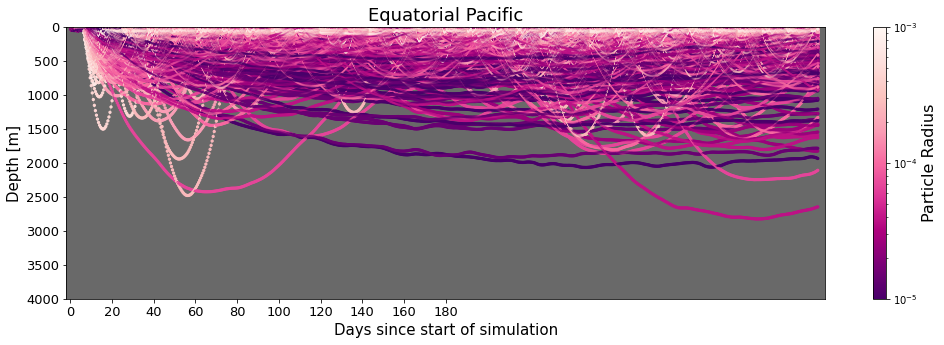

In [18]:
maxdepth = 4000
fig = plt.figure(figsize=(17,5))
ax = plt.axes()

sc = ax.scatter(ds['days'].T[:,::f_plt], ds['z'].T[:,::f_plt], s=5, c=np.tile(ds['r_pl'].T[::f_plt],[len(ds['obs']),1]),cmap=r_pl_cmap,norm=mcolors.LogNorm(vmin=ds['r_pl'].min(), vmax=ds['r_pl'].max()),zorder=2)
ln = ax.plot(ds['days'].T[:,::f_plt], ds['z'].T[:,::f_plt], c='mistyrose',linewidth=0.2,zorder=1)
ax.set_title(regions[region], fontsize=18)
ax.set_ylabel('Depth [m]', fontsize=15)
ax.set_xlabel('Days since start of simulation', fontsize=15)
ax.tick_params(axis='both', labelsize=13)
ax.set_facecolor('dimgray')
ax.set_ylim(maxdepth,0)
ax.set_xlim(-2,362)
# axs[0].set_xticks([0,10,20,30,40,50,60,70,80,90])
ax.set_xticks([0,20,40,60,80,100,120,140,160,180])
# ax1.invert_yaxis()


cb = fig.colorbar(sc, ax=ax)
cb.set_label('Particle Radius', fontsize=16)
plt.show()

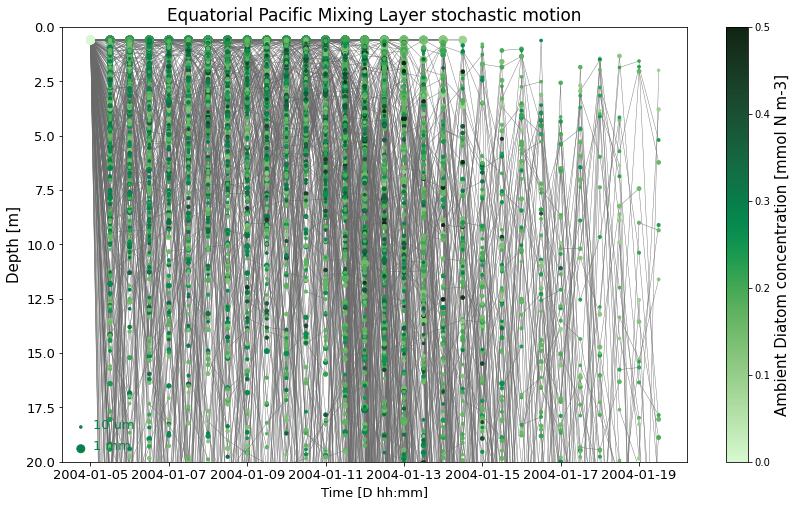

In [19]:
fig = plt.figure(figsize=(14,8))
ax = plt.axes()

tend = 30

sc = ax.scatter(times.T[:tend,::f_plt], depths.T[:tend,::f_plt], s=np.tile(sqrtsizes[::f_plt]*2000,[len(ds['obs'][:tend]),1]), c=algae.T[:tend,::f_plt],cmap='cmo.algae', vmax=0.5, zorder=2)
# sc = ax.scatter(ds['time'].T[:tend,::f_plt], ds['z'].T[:tend,::f_plt], s=np.tile(sqrtsizes[::f_plt]*1000,[len(ds['obs'][:tend]),1]), c=np.tile(ds['r_pl'].T[::f_plt],[len(ds['obs'][:tend]),1]),cmap=r_pl_cmap,norm=mcolors.LogNorm(vmin=ds['r_pl'].min(), vmax=ds['r_pl'].max()),zorder=2)
ln = ax.plot(times.T[:tend,::f_plt], depths.T[:tend,::f_plt], color='dimgray',linewidth=0.4,zorder=1)
ax.set_title('Equatorial Pacific Mixing Layer stochastic motion', fontsize=17)
ax.set_ylabel('Depth [m]', fontsize=15)
ax.set_xlabel('Time [D hh:mm]', fontsize=13)
ax.tick_params(axis='both', labelsize=13)
# ax.set_facecolor('dimgray')
ax.set_ylim(20,0)

ax.scatter([0.03,0.03],[0.03,0.08],color=plt.get_cmap('cmo.algae')(150),s=[np.max(sqrtsizes)*2000,np.min(sqrtsizes)*2000], zorder=5, transform=ax.transAxes)

size_text0 = ax.text(0.05, 0.05,'1 mm',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes, fontsize=13, color=plt.get_cmap('cmo.algae')(150)) # Initialise time ticker
size_text1 = ax.text(0.05, 0.1,'10 um',horizontalalignment='left',verticalalignment='top', transform=ax.transAxes, fontsize=13, color=plt.get_cmap('cmo.algae')(150)) # Initialise time ticker


cb = fig.colorbar(sc, ax=ax)
cb.set_label('Ambient Diatom concentration [mmol N m-3]', fontsize=15)
plt.show()

In [20]:
depthbins = np.linspace(0,3000,100)
starttimes=(ds['time'][0,:]-np.timedelta64(int(outputdt/2.), 'h')).values
endtime = (ds['time'][0,-1]+np.timedelta64(int(outputdt/2.), 'h')).values
timebins = np.append(starttimes,endtime)

In [21]:
split_ds = list(ds.groupby_bins('r_pl',sizebinedges[::-1]))

In [22]:
depth_densities = np.zeros((len(split_ds),len(ds['obs']),len(depthbins)-1))

for i in range(len(depth_densities)):
    for j in range(len(ds['obs'])):
        values, bins = np.histogram(split_ds[i][1]['z'].isel(obs=j), depthbins)
        depth_densities[i,j] = values/len(split_ds[i][1]['traj'])

Text(0.5, 0.98, 'Particle depth distribution in Equatorial Pacific (logarithmic)')

/nethome/6492215/.conda/envs/py3_parcels/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


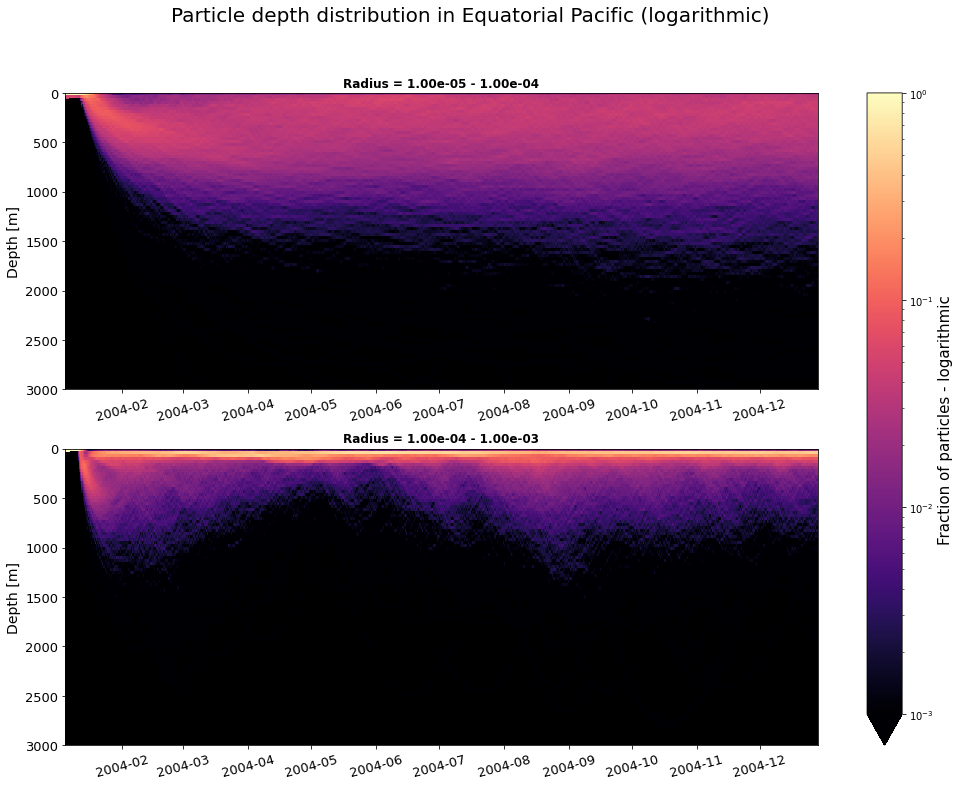

In [23]:
fig = plt.figure(figsize=(15,12),constrained_layout=True)
gs = gridspec.GridSpec(ncols=3, nrows=2, width_ratios=[1,1,0.1], figure=fig)
ax1 = fig.add_subplot(gs[0, :2])
ax2 = fig.add_subplot(gs[1, :2])
ax3 = fig.add_subplot(gs[:, 2])
axes=[ax1, ax2]

for c, ax in enumerate(axes):
    ax.set_facecolor('k')
    pc = ax.pcolormesh(timebins,depthbins,depth_densities[c].T, cmap='magma',norm=mcolors.LogNorm(vmin=1e-3, vmax=1))
    #ax.set_title(mixing[0]+' mixing', fontsize=14)
    ax.set_ylabel('Depth [m]', fontsize=14)
    ax.tick_params(axis='both', labelsize=13)
    ax.tick_params(axis='x', rotation=15)
    ax.set_ylim(3000, 0)
    #cb.set_label('Fraction of particles - logarithmic', size=15)
    ax.set_title('Radius = '+"{left:.2e} - {right:.2e}".format(left=split_ds[c][0].left, right=split_ds[c][0].right),fontweight='bold')
        
cb = fig.colorbar(pc, cax=ax3, extend='min')
cb.set_label('Fraction of particles - logarithmic', size=15)
fig.suptitle('Particle depth distribution in '+regions[region]+' (logarithmic)', fontsize=20)

In [24]:
ds_mld = ds.where(ds['mld']<=1)
ds_deep = ds.where(ds['mld']>1)

In [25]:
dslist = [ds_mld, ds_deep]

In [26]:
w_bins = [-1e0, -1e-1, -1e-2, -1e-3, -1e-4, -1e-5, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0]
w_bincenters = [-2e-1, -2e-2, -2e-3, -2e-4, -2e-5, 0, 2e-5, 2e-4, 2e-3, 2e-2, 2e-1]
w_list = ['w_m', 'vs_init', 'w_adv']#, 'w_m_b']
w_list_names = ['Stochastic Kz', 'Potential settling velocity', 'Model advection']
w_pdf = np.zeros((2,len(w_list),len(w_bins)-1))
linestyles=['-','-.']

for j,w in enumerate(w_list):
    vals_mld, bins_mld = np.histogram(ds_mld[w], w_bins)
    w_pdf[0,j,:] = vals_mld/ds_mld[w].size
    vals_deep, bins_deep = np.histogram(ds_deep[w], w_bins)
    w_pdf[1,j,:] = vals_deep/ds_deep[w].size

In [27]:
w_widths = np.ones(w_pdf.shape[2])
w_centers = np.arange(w_pdf.shape[2])
w_edges = np.arange(w_pdf.shape[2]+1)-0.5
w_bin_str = [np.format_float_scientific(w,2,exp_digits=1) for w in w_bins]

In [28]:
w_vel_cmap = ['salmon', 'lime', 'cornflowerblue', 'gold']

In [29]:
w_pdf_sizes = np.zeros((2,len(w_list),len(sizebinedges)-1,len(w_bins)-1))

for i,ds_l in enumerate(dslist):
    split_ds = list(ds_l.groupby_bins('r_pl',sizebinedges[::-1]))
    for j,w in enumerate(w_list):
        for k,ds_r in enumerate(split_ds):
            vals, bins = np.histogram(ds_r[1][w], w_bins)
            w_pdf_sizes[i,j,k,:] = vals/ds_r[1][w].size

In [30]:
mld_text = ['Above mixed layer', 'Below mixed layer']

In [31]:
w_edges

array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5,
       10.5])

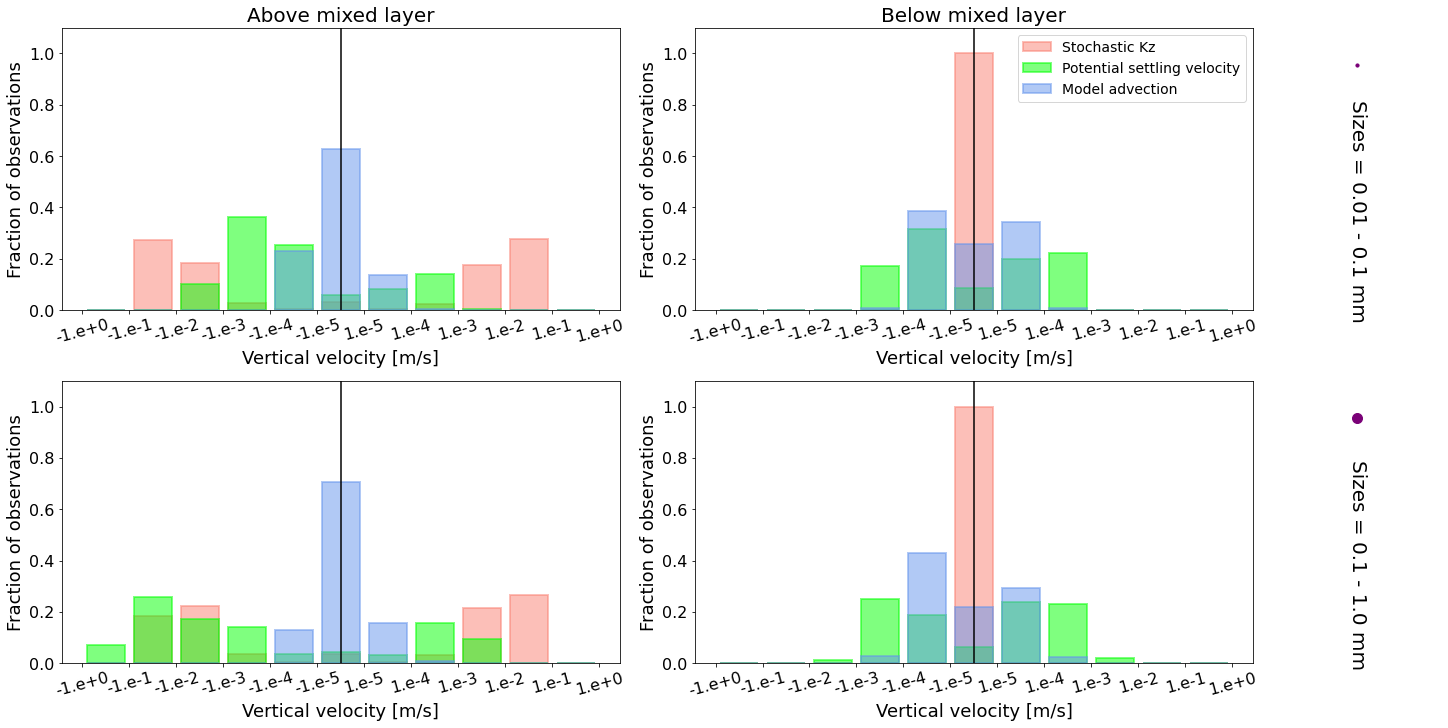

In [32]:
fig = plt.figure(figsize=(20,10),constrained_layout=True)
# fig.suptitle('Vertical velocities', fontsize=24, y=1.03)
gs = gridspec.GridSpec(ncols=3, nrows=2, width_ratios=[1,1,0.3],figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[0, 1])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[0, 2])
ax6 = fig.add_subplot(gs[1, 2])
axes = [[ax1, ax2], [ax3, ax4], [ax5, ax6]]

for i,ds in enumerate(dslist):
    split_ds = list(ds.groupby_bins('r_pl',sizebinedges[::-1]))
    for k, ds_r in enumerate(split_ds):
        for j,w in enumerate(w_list):
            axes[i][k].bar(w_centers, w_pdf_sizes[i,j,k], align='center', alpha=0.5, color=w_vel_cmap[j], edgecolor=w_vel_cmap[j], linewidth=2, label=w_list_names[j], zorder=1)
        axes[i][k].set_ylim(0,1.1)
        axes[i][k].set_xticks(w_edges)
        axes[i][k].vlines(5, 0, 1.2, colors='k', zorder=2)
        axes[i][k].set_xticklabels(w_bin_str)
#         axes[i][k].invert_yaxis()
        axes[i][k].tick_params(axis='both', labelsize=16)
        axes[i][k].tick_params(axis='x', rotation=15)
        axes[i][k].set_ylabel('Fraction of observations', fontsize=18)
        axes[i][k].set_xlabel('Vertical velocity [m/s]', fontsize=18)
    axes[i][0].set_title(mld_text[i], fontsize=20)
    
split_ds = list(dslist[0].groupby_bins('r_pl',sizebinedges[::-1]))
for k, ds_r in enumerate(split_ds):
    axes[2][k].scatter(0.5,0.87,s=sizebinedges[-k-1]*1000000,color=r_pl_clist[0])
    axes[2][k].set_ylim(0,1)
    axes[2][k].text(0.5,0.35,'Sizes = '+ str(ds_r[0].left*1000)+' - '+str(ds_r[0].right*1000)+' mm',rotation=270,fontsize=20, horizontalalignment='center',verticalalignment='center')
    axes[2][k].axis('off')
axes[1][0].legend(fontsize=14, loc='upper right')#bbox_to_anchor=(0.7, 1))

IndexError: too many indices

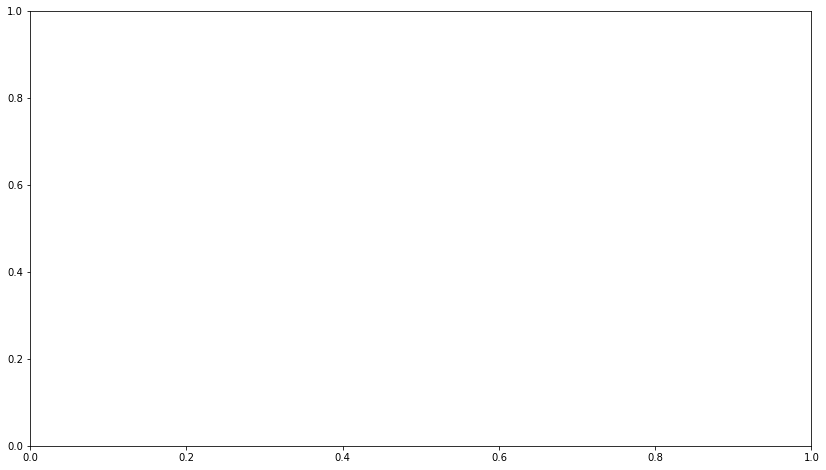

In [33]:
fig = plt.figure(figsize=(14,8))
ax=plt.axes()

for i, r in enumerate(split_ds):
    ax.plot(r[1]['time'].T[:,::f_plt], r[1]['z'].T[:,::f_plt], marker='o', markersize=3, c=r_pl_clist[2*i], alpha=0.3)
ax.set_facecolor('dimgray')
ax.set_ylim(1000,0)
ax.set_title('Sinking trajectories per particle size bin')
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Time')
ax.tick_params(axis='x', rotation=45)

custom_lines = [Line2D([0], [0], color=r_pl_clist[0], lw=4),
                Line2D([0], [0], color=r_pl_clist[2], lw=4)]#,
#                 Line2D([0], [0], color=r_pl_clist[2], lw=4),
#                 Line2D([0], [0], color=r_pl_clist[3], lw=4)]

ax.legend(custom_lines, ["{left:.1e} - {right:.1e}".format(left=split_ds[0][0].left, right=split_ds[0][0].right), "{:.1e} - {:.1e}".format(split_ds[1][0].left, split_ds[1][0].right)], title='Plastic Radius [m]', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [34]:
mld = np.mean(np.divide(ds['z'],ds['mld']),axis=0)

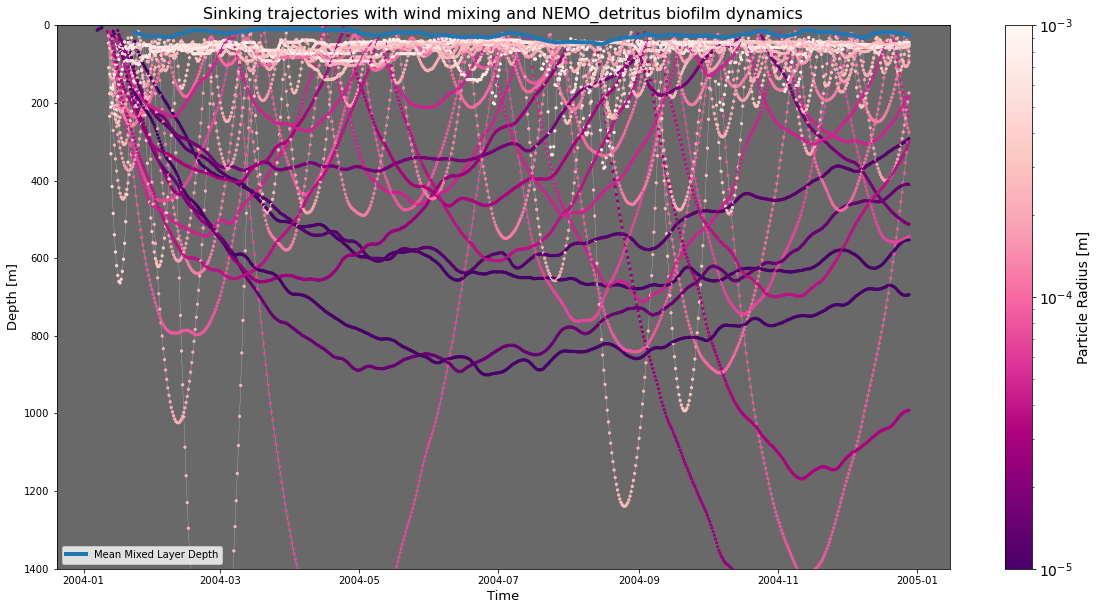

In [51]:
fig = plt.figure(figsize=(20,10))
ax1=plt.axes()

sc = ax1.scatter(ds['time'].T[:,::f_plt], ds['z'].T[:,::f_plt], s=5, c=ds['r_pl'].T[:,::f_plt],cmap=r_pl_cmap,norm=mcolors.LogNorm(vmin=ds['r_pl'].min(), vmax=ds['r_pl'].max()),zorder=2)
ln = ax1.plot(ds['time'].T[:,::f_plt], ds['z'].T[:,::f_plt], c='mistyrose',linewidth=0.2,zorder=1)
ax1.plot(ds['time'][0,:], mld, linewidth=4, label='Mean Mixed Layer Depth')
ax1.set_title('Sinking trajectories with wind mixing and '+death+' biofilm dynamics', fontsize=16)
ax1.set_ylabel('Depth [m]', fontsize=13)
ax1.set_xlabel('Time', fontsize=13)
ax1.set_facecolor('dimgray')
ax1.set_ylim(1400,0)

cb = fig.colorbar(sc, ax=ax1)
cb.set_label('Particle Radius [m]', fontsize=14)
cb.ax.tick_params(labelsize=14)
ax1.legend(loc = 'lower left')
plt.show()

/nethome/6492215/.conda/envs/py3_parcels/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


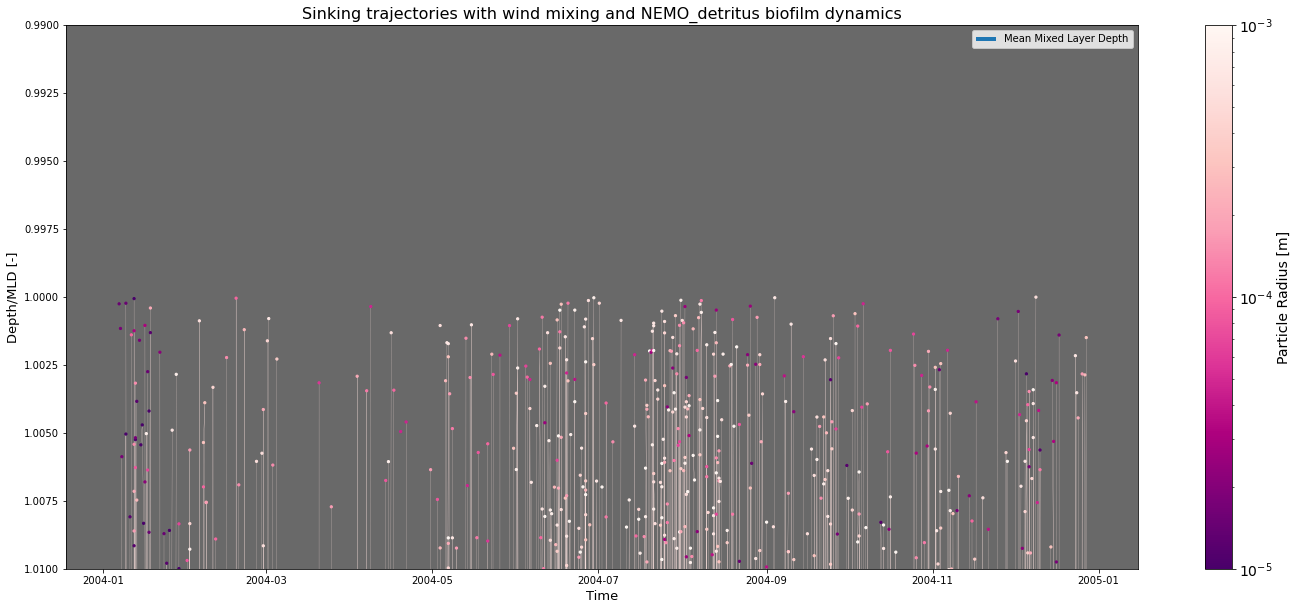

In [58]:
fig = plt.figure(figsize=(24,10))
ax1=plt.axes()

sc = ax1.scatter(ds['time'].T[:,::f_plt], ds['mld'].T[:,::f_plt], s=5, c=ds['r_pl'].T[:,::f_plt],cmap=r_pl_cmap,norm=mcolors.LogNorm(vmin=ds['r_pl'].min(), vmax=ds['r_pl'].max()),zorder=2)
ln = ax1.plot(ds['time'].T[:,::f_plt], ds['mld'].T[:,::f_plt], c='mistyrose',linewidth=0.2,zorder=1)
ax1.hlines(1, np.nanmin(ds['time']), np.nanmax(ds['time']), linewidth=4, label='Mean Mixed Layer Depth')
ax1.set_title('Sinking trajectories with wind mixing and '+death+' biofilm dynamics', fontsize=16)
ax1.set_ylabel('Depth/MLD [-]', fontsize=13)
ax1.set_xlabel('Time', fontsize=13)
ax1.set_facecolor('dimgray')
ax1.set_ylim(1.01,0.99)

cb = fig.colorbar(sc, ax=ax1)
cb.set_label('Particle Radius [m]', fontsize=14)
cb.ax.tick_params(labelsize=14)
ax1.legend()
plt.show()

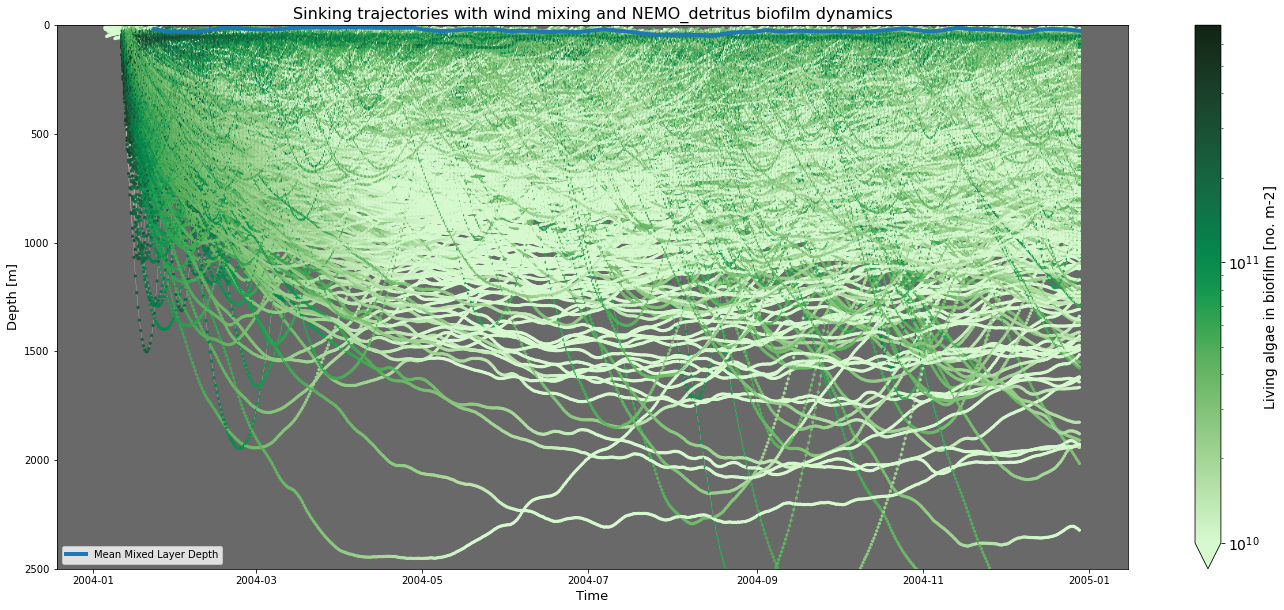

In [75]:
fig = plt.figure(figsize=(24,10))
ax1=plt.axes()

sc = ax1.scatter(ds['time'].T[:,::f_plt], ds['z'].T[:,::f_plt], s=5, c=ds['a'].T[:,::f_plt],cmap='cmo.algae',norm=mcolors.LogNorm(vmin=max(ds['a'].min(), 1e10), vmax=ds['a'].max()),zorder=2)
ln = ax1.plot(ds['time'].T[:,::f_plt], ds['z'].T[:,::f_plt], c='mistyrose',linewidth=0.2,zorder=1)
ax1.plot(ds['time'][0,:], mld, linewidth=4, label='Mean Mixed Layer Depth')
ax1.set_title('Sinking trajectories with wind mixing and '+death+' biofilm dynamics', fontsize=16)
ax1.set_ylabel('Depth [m]', fontsize=13)
ax1.set_xlabel('Time', fontsize=13)
ax1.set_facecolor('dimgray')
ax1.set_ylim(2500,0)

cb = fig.colorbar(sc, ax=ax1, extend='min')
cb.set_label('Living algae in biofilm [no. m-2]', fontsize=14)
cb.ax.tick_params(labelsize=14)
ax1.legend(loc = 'lower left')
plt.show()

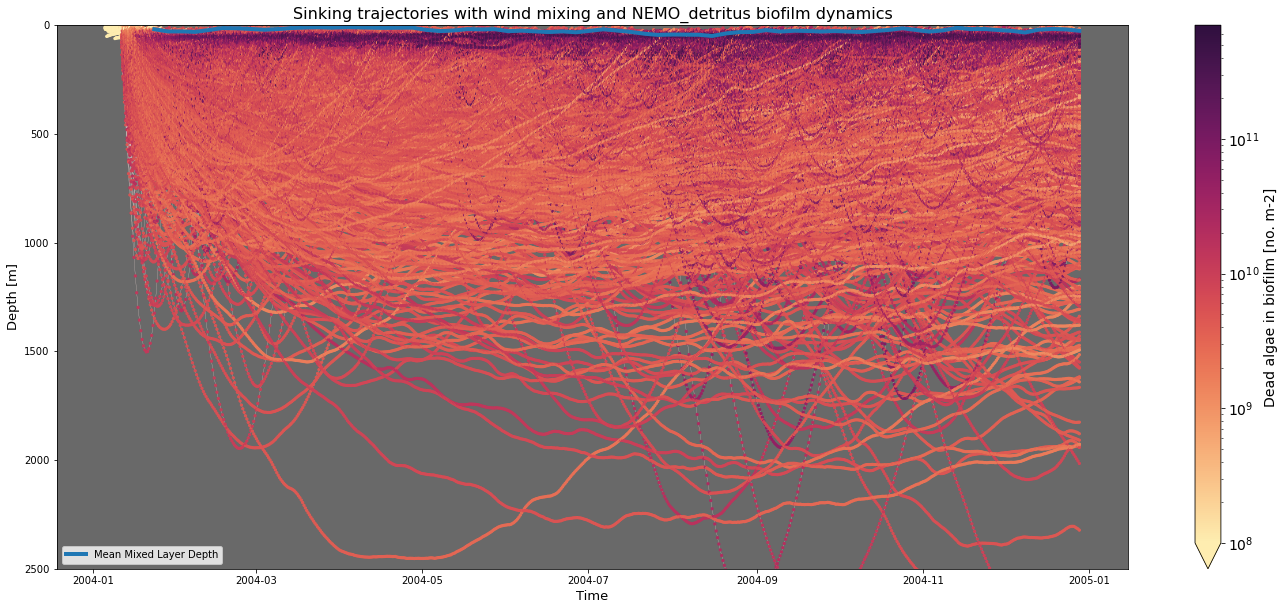

In [77]:
fig = plt.figure(figsize=(24,10))
ax1=plt.axes()

sc = ax1.scatter(ds['time'].T[:,::f_plt], ds['z'].T[:,::f_plt], s=5, c=ds['a_dead'].T[:,::f_plt],cmap='cmo.matter',norm=mcolors.LogNorm(vmin=max(ds['a'].min(), 1e8), vmax=ds['a'].max()),zorder=2)
ln = ax1.plot(ds['time'].T[:,::f_plt], ds['z'].T[:,::f_plt], c='mistyrose',linewidth=0.2,zorder=1)
ax1.plot(ds['time'][0,:], mld, linewidth=4, label='Mean Mixed Layer Depth')
ax1.set_title('Sinking trajectories with wind mixing and '+death+' biofilm dynamics', fontsize=16)
ax1.set_ylabel('Depth [m]', fontsize=13)
ax1.set_xlabel('Time', fontsize=13)
ax1.set_facecolor('dimgray')
ax1.set_ylim(2500,0)

cb = fig.colorbar(sc, ax=ax1, extend='min')
cb.set_label('Dead algae in biofilm [no. m-2]', fontsize=14)
cb.ax.tick_params(labelsize=14)
ax1.legend(loc = 'lower left')
plt.show()

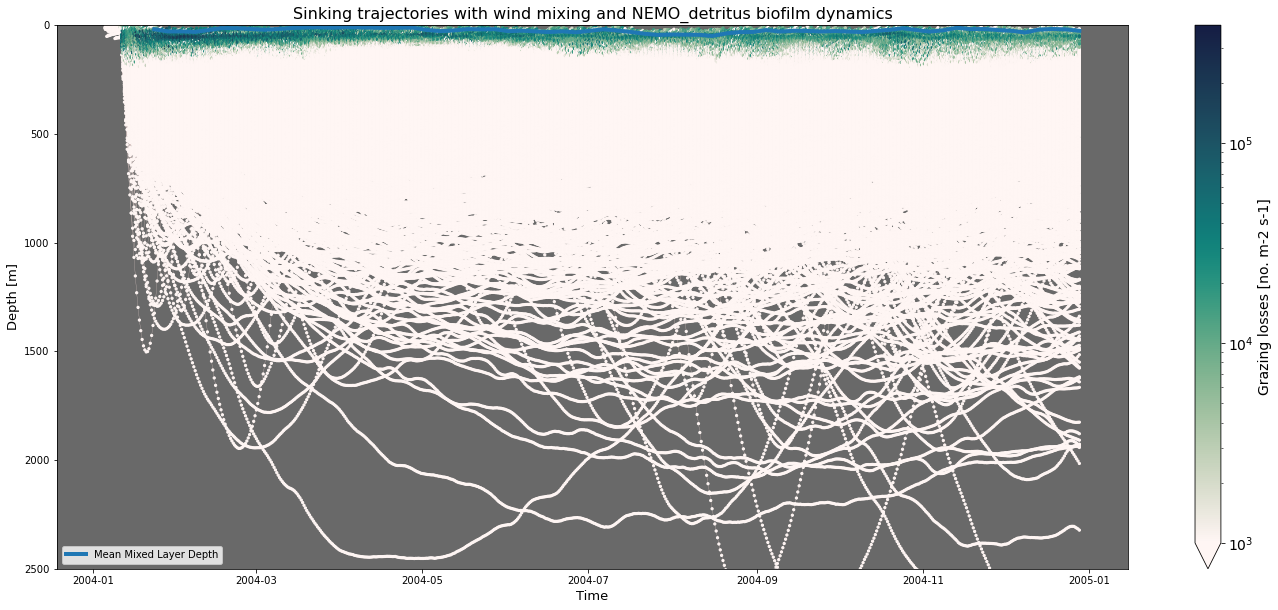

In [78]:
fig = plt.figure(figsize=(24,10))
ax1=plt.axes()

sc = ax1.scatter(ds['time'].T[:,::f_plt], ds['z'].T[:,::f_plt], s=5, c=ds['a_gr'].T[:,::f_plt],cmap='cmo.tempo',norm=mcolors.LogNorm(vmin=max(ds['a_gr'].min(), 1e3), vmax=ds['a_gr'].max()),zorder=2)
ln = ax1.plot(ds['time'].T[:,::f_plt], ds['z'].T[:,::f_plt], c='mistyrose',linewidth=0.2,zorder=1)
ax1.plot(ds['time'][0,:], mld, linewidth=4, label='Mean Mixed Layer Depth')
ax1.set_title('Sinking trajectories with wind mixing and '+death+' biofilm dynamics', fontsize=16)
ax1.set_ylabel('Depth [m]', fontsize=13)
ax1.set_xlabel('Time', fontsize=13)
ax1.set_facecolor('dimgray')
ax1.set_ylim(2500,0)

cb = fig.colorbar(sc, ax=ax1, extend='min')
cb.set_label('Grazing losses [no. m-2 s-1]', fontsize=14)
cb.ax.tick_params(labelsize=14)
ax1.legend(loc = 'lower left')
plt.show()

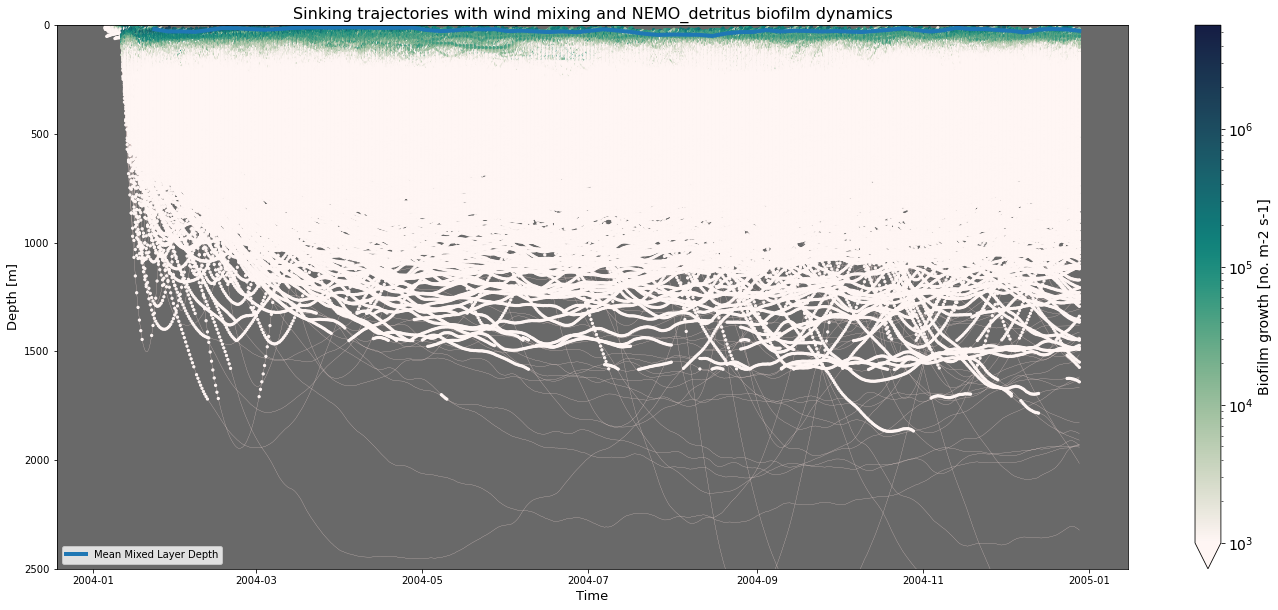

In [80]:
fig = plt.figure(figsize=(24,10))
ax1=plt.axes()

sc = ax1.scatter(ds['time'].T[:,::f_plt], ds['z'].T[:,::f_plt], s=5, c=ds['a_growth'].T[:,::f_plt],cmap='cmo.tempo',norm=mcolors.LogNorm(vmin=max(ds['a_growth'].min(), 1e3), vmax=ds['a_growth'].max()),zorder=2)
ln = ax1.plot(ds['time'].T[:,::f_plt], ds['z'].T[:,::f_plt], c='mistyrose',linewidth=0.2,zorder=1)
ax1.plot(ds['time'][0,:], mld, linewidth=4, label='Mean Mixed Layer Depth')
ax1.set_title('Sinking trajectories with wind mixing and '+death+' biofilm dynamics', fontsize=16)
ax1.set_ylabel('Depth [m]', fontsize=13)
ax1.set_xlabel('Time', fontsize=13)
ax1.set_facecolor('dimgray')
ax1.set_ylim(2500,0)

cb = fig.colorbar(sc, ax=ax1, extend='min')
cb.set_label('Biofilm growth [no. m-2 s-1]', fontsize=14)
cb.ax.tick_params(labelsize=14)
ax1.legend(loc = 'lower left')
plt.show()

In [65]:
# fig = plt.figure(figsize=(18,12), constrained_layout=True)
# fig.suptitle('$\\Delta \\rho$', fontsize=22)
# ax = plt.axes()

# for i, r in enumerate(split_ds):
#     ax.plot(r[1]['time'].T[1:,::f_plt], r[1]['delta_rho'].T[1:,::f_plt], marker='o', markersize=3,c=r_pl_clist[2*i], alpha = 0.4)
# ax.set_facecolor('dimgray')
# ax.grid(b=True, axis='y')
# ax.set_ylabel('$\\Delta \\rho$')
# ax.set_xlabel('Time')
# ax.tick_params(axis='x', rotation=45)
# ax.set_ylim(-0.2,0.4)

# custom_lines = [Line2D([0], [0], color=r_pl_clist[0], lw=4),
#                 Line2D([0], [0], color=r_pl_clist[1], lw=4)]#,
# #                 Line2D([0], [0], color=r_pl_clist[2], lw=4),
# #                 Line2D([0], [0], color=r_pl_clist[3], lw=4)]

# ax.legend(custom_lines, ["{left:.1e} - {right:.1e}".format(left=split_ds[0][0].left, right=split_ds[0][0].right), "{left:.1e} - {right:.1e}".format(left=split_ds[1][0].left, right=split_ds[1][0].right)], title='Plastic Radius', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.show()

In [67]:
# fig = plt.figure(figsize=(18,12))
# fig.suptitle('Biofilm thickness', fontsize=22)
# ax = plt.axes()

# for i, r in enumerate(split_ds):
#     ax.plot(r[1]['time'].T[1:,::f_plt], r[1]['r_tot'].T[1:,::f_plt] - r[1]['r_pl'].T[::f_plt], marker='o', markersize=3,c=r_pl_clist[2*i], alpha = 0.4)
# ax.set_facecolor('dimgray')
# ax.grid(b=True, axis='y')
# ax.set_ylabel('Biofilm thickness [m]')
# ax.set_xlabel('Time')
# ax.tick_params(axis='x', rotation=45)
# # ax.set_ylim(-0.2,0.2)

# custom_lines = [Line2D([0], [0], color=r_pl_clist[0], lw=4),
#                 Line2D([0], [0], color=r_pl_clist[1], lw=4)]#,
# #                 Line2D([0], [0], color=r_pl_clist[2], lw=4),
# #                 Line2D([0], [0], color=r_pl_clist[3], lw=4)]

# ax.legend(custom_lines, ["{left:.1e} - {right:.1e}".format(left=split_ds[0][0].left, right=split_ds[0][0].right), "{left:.1e} - {right:.1e}".format(left=split_ds[1][0].left, right=split_ds[1][0].right)], title='Plastic Radius', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.show()

In [68]:
# fig = plt.figure(figsize=(18,12))
# fig.suptitle('Relative biofilm thickness', fontsize=22)
# ax = plt.axes()

# for i, r in enumerate(split_ds):
#     ax.plot(r[1]['time'].T[1:,::f_plt], (r[1]['r_tot'].T[1:,::f_plt] - r[1]['r_pl'].T[::f_plt])/r[1]['r_pl'].T[::f_plt], marker='o', markersize=3,c=r_pl_clist[2*i], alpha = 0.4)
# ax.set_facecolor('dimgray')
# ax.grid(b=True, axis='y')
# ax.set_ylabel('Relative biofilm thickness [-]')
# ax.set_xlabel('Time')
# ax.tick_params(axis='x', rotation=45)
# # ax.set_ylim(-0.2,0.2)

# custom_lines = [Line2D([0], [0], color=r_pl_clist[0], lw=4),
#                 Line2D([0], [0], color=r_pl_clist[1], lw=4)]#,
# #                 Line2D([0], [0], color=r_pl_clist[2], lw=4),
# #                 Line2D([0], [0], color=r_pl_clist[3], lw=4)]

# ax.legend(custom_lines, ["{left:.1e} - {right:.1e}".format(left=split_ds[0][0].left, right=split_ds[0][0].right), "{left:.1e} - {right:.1e}".format(left=split_ds[1][0].left, right=split_ds[1][0].right)], title='Plastic Radius', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.show()

In [69]:
# fig = plt.figure(figsize=(18,12), constrained_layout=True)
# fig.suptitle('N:Si', fontsize=22)
# ax = plt.axes()

# for i, r in enumerate(split_ds):
#     ax.plot(r[1]['time'].T[1:,::f_plt], r[1]['Si_N'].T[1:,::f_plt], marker='o', markersize=3,c=r_pl_clist[2*i], alpha = 0.7)
# ax.set_facecolor('dimgray')
# ax.grid(b=True, axis='y')
# ax.set_ylabel('N:Si')
# ax.set_xlabel('Time')
# ax.tick_params(axis='x', rotation=45)
# # ax.set_ylim(-0.2,0.2)

# custom_lines = [Line2D([0], [0], color=r_pl_clist[0], lw=4),
#                 Line2D([0], [0], color=r_pl_clist[1], lw=4)]#,
# #                 Line2D([0], [0], color=r_pl_clist[2], lw=4),
# #                 Line2D([0], [0],color=r_pl_clist[3], lw=4)]

# ax.legend(custom_lines, ["{left:.1e} - {right:.1e}".format(left=split_ds[0][0].left, right=split_ds[0][0].right), "{left:.1e} - {right:.1e}".format(left=split_ds[1][0].left, right=split_ds[1][0].right)], title='Plastic Radius', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.show()

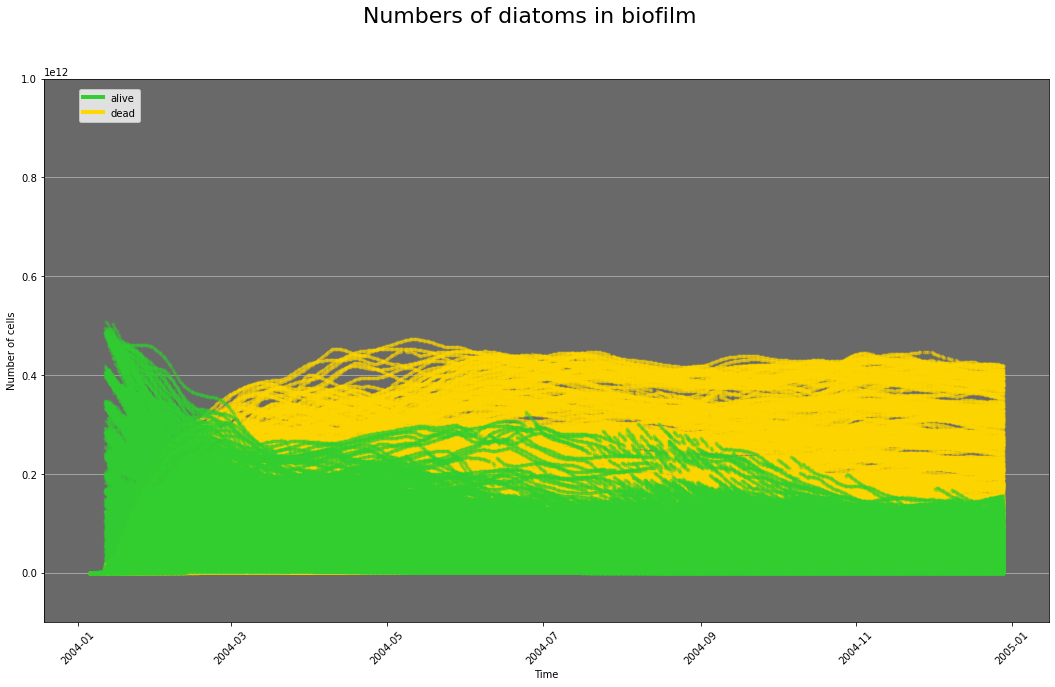

In [83]:
fig = plt.figure(figsize=(18,10))
fig.suptitle('Numbers of diatoms in biofilm', fontsize=22)
ax = plt.axes()

ax.plot(ds['time'].T[1:,::f_plt], ds['a_dead'].T[1:,::f_plt], marker='o', markersize=3,c='gold', alpha = 0.3, label='dead')
ax.plot(ds['time'].T[1:,::f_plt], ds['a'].T[1:,::f_plt], marker='o', markersize=3,c='limegreen', alpha = 0.3, label='alive')
ax.set_facecolor('dimgray')
ax.grid(b=True, axis='y')
ax.set_ylabel('Number of cells')
ax.set_xlabel('Time')
ax.tick_params(axis='x', rotation=45)
ax.set_ylim(-1e11,1e12)

custom_lines = [Line2D([0], [0], color='limegreen', lw=4),
                Line2D([0], [0], color='gold', lw=4)]

ax.legend(custom_lines, ["alive", "dead"], bbox_to_anchor=(0.1, 0.99), loc='upper right')
plt.show()

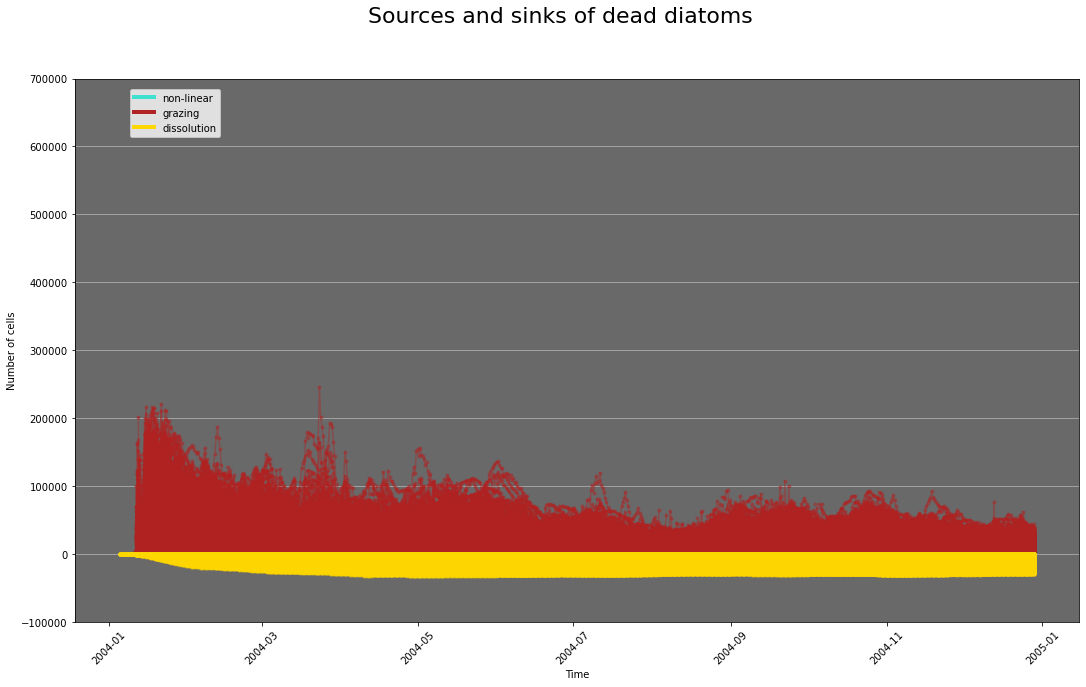

In [71]:
fig = plt.figure(figsize=(18,10))
fig.suptitle('Sources and sinks of dead diatoms', fontsize=22)
ax = plt.axes()

ax.plot(ds['time'].T[1:,::f_plt], ds['a_indirect'].T[1:,::f_plt], marker='o', markersize=3,c='firebrick', alpha = 0.4, label='grazing')
ax.plot(ds['time'].T[1:,::f_plt], ds['a_direct'].T[1:,::f_plt], marker='o', markersize=3,c='turquoise', alpha = 0.4, label='non-linear')
ax.plot(ds['time'].T[1:,::f_plt], -ds['a_diss'].T[1:,::f_plt], marker='o', markersize=3,c='gold', alpha = 0.4, label='dissolution')
ax.set_facecolor('dimgray')
ax.grid(b=True, axis='y')
ax.set_ylabel('Number of cells')
ax.set_xlabel('Time')
ax.tick_params(axis='x', rotation=45)
ax.set_ylim(-1e5,7e5)

custom_lines = [Line2D([0], [0], color='turquoise', lw=4),
                Line2D([0], [0], color='firebrick', lw=4),
                Line2D([0], [0], color='gold', lw=4)]

ax.legend(custom_lines, ["non-linear", "grazing", "dissolution"], bbox_to_anchor=(0.15, 0.99), loc='upper right')
plt.show()

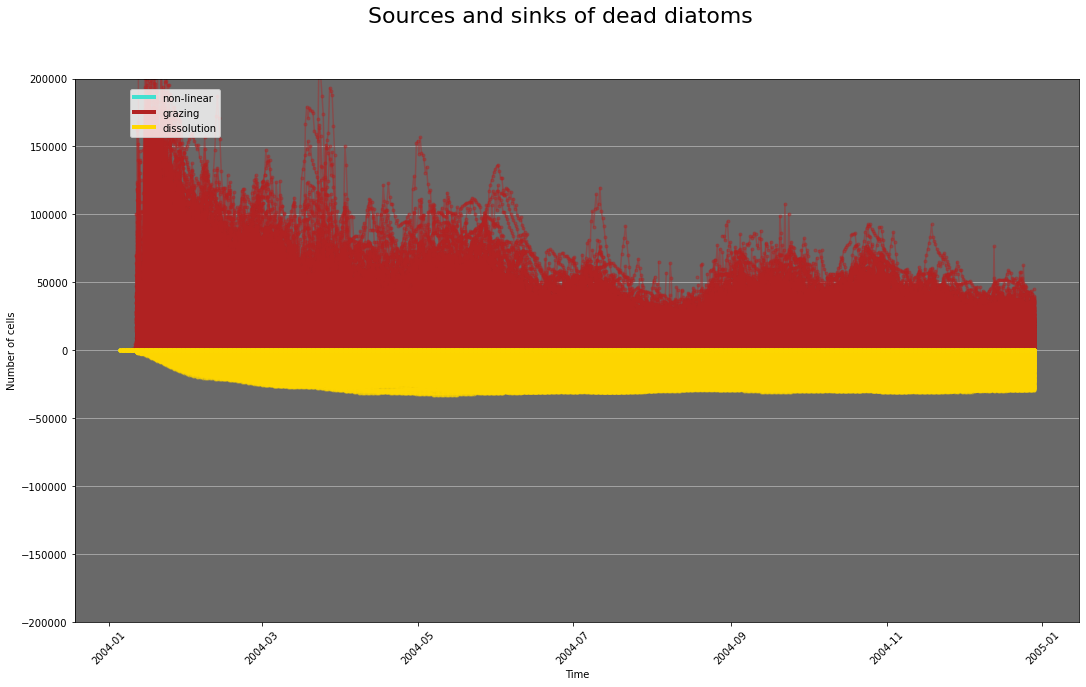

In [85]:
fig = plt.figure(figsize=(18,10))
fig.suptitle('Sources and sinks of dead diatoms', fontsize=22)
ax = plt.axes()

ax.plot(ds['time'].T[1:,::f_plt], ds['a_indirect'].T[1:,::f_plt], marker='o', markersize=3,c='firebrick', alpha = 0.4, label='grazing')
ax.plot(ds['time'].T[1:,::f_plt], ds['a_direct'].T[1:,::f_plt], marker='o', markersize=3,c='turquoise', alpha = 0.4, label='non-linear')
ax.plot(ds['time'].T[1:,::f_plt], -ds['a_diss'].T[1:,::f_plt], marker='o', markersize=3,c='gold', alpha = 0.4, label='dissolution')
ax.set_facecolor('dimgray')
ax.grid(b=True, axis='y')
ax.set_ylabel('Number of cells')
ax.set_xlabel('Time')
ax.tick_params(axis='x', rotation=45)
ax.set_ylim(-2e5,2e5)

custom_lines = [Line2D([0], [0], color='turquoise', lw=4),
                Line2D([0], [0], color='firebrick', lw=4),
                Line2D([0], [0], color='gold', lw=4)]

ax.legend(custom_lines, ["non-linear", "grazing", "dissolution"], bbox_to_anchor=(0.15, 0.99), loc='upper right')
plt.show()

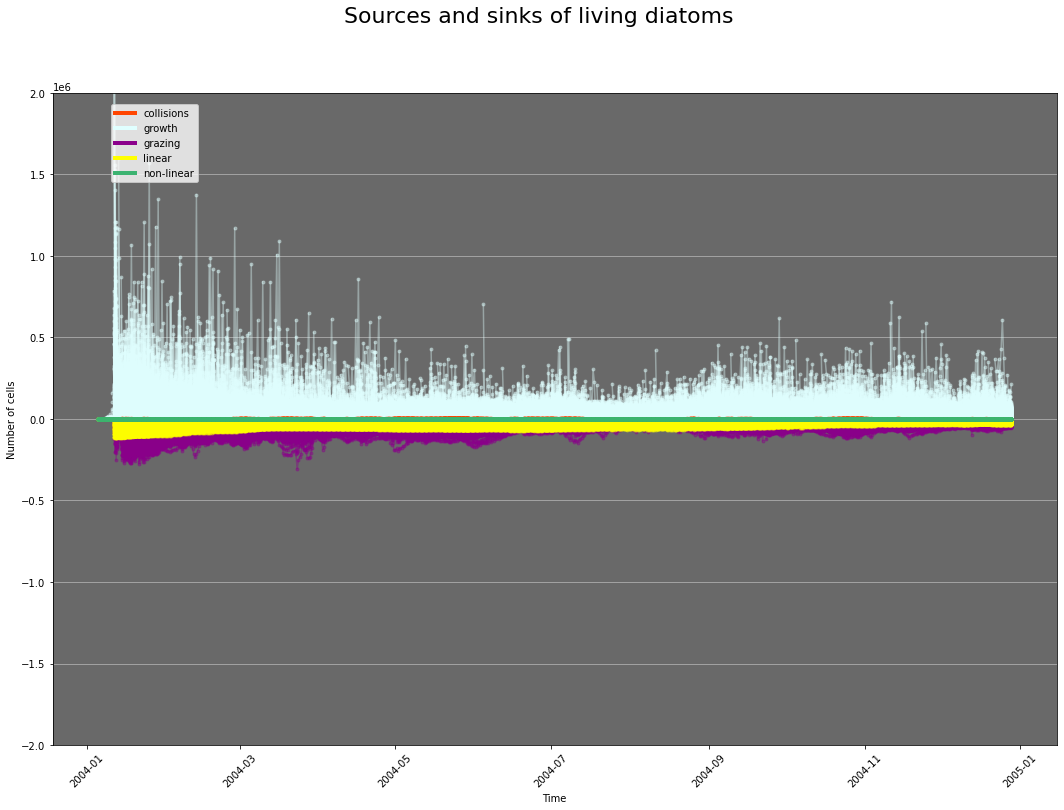

In [84]:
fig = plt.figure(figsize=(18,12))
fig.suptitle('Sources and sinks of living diatoms', fontsize=22)
ax = plt.axes()

ax.plot(ds['time'].T[1:,::f_plt], ds['a_growth'].T[1:,::f_plt], marker='o', markersize=3,c='lightcyan', alpha = 0.4)
ax.plot(ds['time'].T[1:,::f_plt], ds['a_coll'].T[1:,::f_plt], marker='o', markersize=3,c='orangered', alpha = 0.4)
ax.plot(ds['time'].T[1:,::f_plt], -ds['a_gr'].T[1:,::f_plt], marker='o', markersize=3,c='darkmagenta', alpha = 0.4)
ax.plot(ds['time'].T[1:,::f_plt], -ds['a_l'].T[1:,::f_plt], marker='o', markersize=3,c='yellow', alpha = 0.4)
ax.plot(ds['time'].T[1:,::f_plt], -ds['a_nl'].T[1:,::f_plt], marker='o', markersize=3,c='mediumseagreen', alpha = 0.4)

ax.set_facecolor('dimgray')
ax.grid(b=True, axis='y')
ax.set_ylabel('Number of cells')
ax.set_xlabel('Time')
ax.tick_params(axis='x', rotation=45)
ax.set_ylim(-2e6,2e6)

custom_lines = [Line2D([0], [0], color='orangered', lw=4),
                Line2D([0], [0], color='lightcyan', lw=4),
                Line2D([0], [0], color='darkmagenta', lw=4),
                Line2D([0], [0], color='yellow', lw=4),
                Line2D([0], [0], color='mediumseagreen', lw=4)]

ax.legend(custom_lines, ["collisions", "growth", "grazing", "linear", "non-linear"], bbox_to_anchor=(0.15, 0.99), loc='upper right')
plt.show()

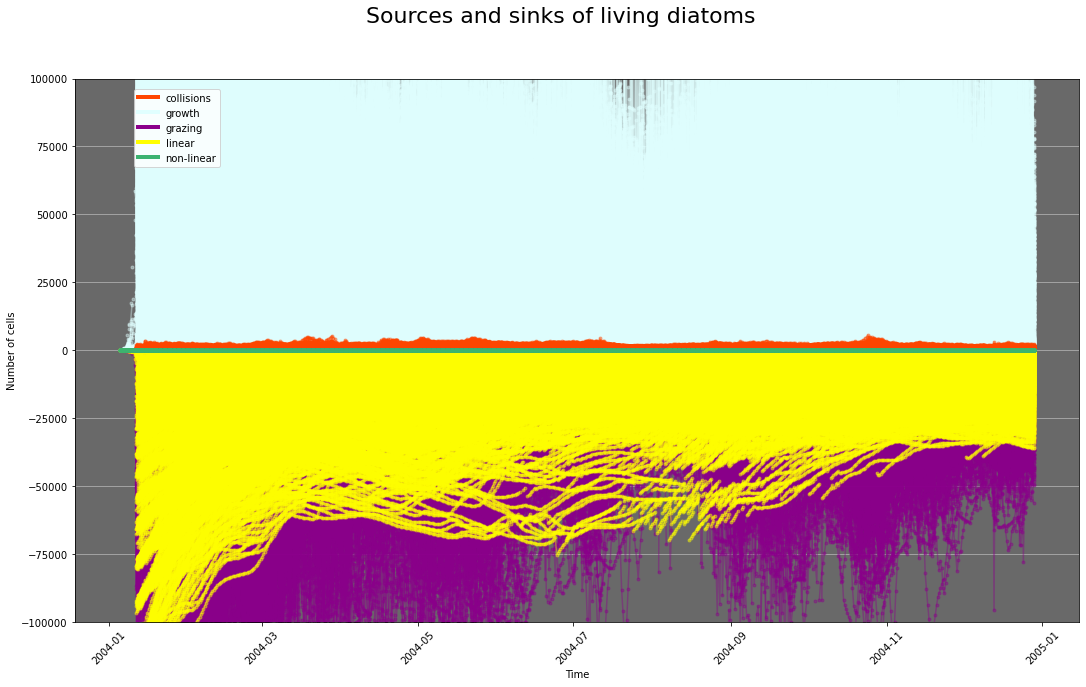

In [74]:
fig = plt.figure(figsize=(18,10))
fig.suptitle('Sources and sinks of living diatoms', fontsize=22)
ax = plt.axes()

ax.plot(ds['time'].T[1:,::f_plt], ds['a_growth'].T[1:,::f_plt], marker='o', markersize=3,c='lightcyan', alpha = 0.4)
ax.plot(ds['time'].T[1:,::f_plt], ds['a_coll'].T[1:,::f_plt], marker='o', markersize=3,c='orangered', alpha = 0.4)
ax.plot(ds['time'].T[1:,::f_plt], -ds['a_gr'].T[1:,::f_plt], marker='o', markersize=3,c='darkmagenta', alpha = 0.4)
ax.plot(ds['time'].T[1:,::f_plt], -ds['a_l'].T[1:,::f_plt], marker='o', markersize=3,c='yellow', alpha = 0.4)
ax.plot(ds['time'].T[1:,::f_plt], -ds['a_nl'].T[1:,::f_plt], marker='o', markersize=3,c='mediumseagreen', alpha = 0.4)

ax.set_facecolor('dimgray')
ax.grid(b=True, axis='y')
ax.set_ylabel('Number of cells')
ax.set_xlabel('Time')
ax.tick_params(axis='x', rotation=45)
ax.set_ylim(-1e5,1e5)

custom_lines = [Line2D([0], [0], color='orangered', lw=4),
                Line2D([0], [0], color='lightcyan', lw=4),
                Line2D([0], [0], color='darkmagenta', lw=4),
                Line2D([0], [0], color='yellow', lw=4),
                Line2D([0], [0], color='mediumseagreen', lw=4)]

ax.legend(custom_lines, ["collisions", "growth", "grazing", "linear", "non-linear"], bbox_to_anchor=(0.15, 0.99), loc='upper right')
plt.show()